# ODE-based models

MEmilio implements various models based on ordinary differential equations (ODEs). ODE-based models are a subclass of compartmental models in which individuals are grouped into subpopulations called compartments.
One example of an ODE-based model implemented in MEmilio is the ODE-SECIR model. This model is particularly suited for pathogens with pre- or asymptomatic infection states and when severe or critical symptoms are possible. The model assumes perfect immunity after recovery. The used infection states or compartments are Susceptible (S), Exposed(E), Non-symptomatically Infected (Ins), Symptomatically Infected (Isy), Severely Infected (Isev), Critically Infected (Icri), Dead (D) and Recovered (R).

The following example shows how to set up and run a simple ODE-SECIR model with 3 sociodemographic groups. The example requires to have the memilio-simulation package installed which can be accessed under https://github.com/SciCompMod/memilio/tree/main/pycode/memilio-simulation.

In [86]:
import memilio.simulation.osecir as osecir
from memilio.simulation import AgeGroup
import numpy as np

In [87]:
# Initialize total population, simulation start time, simulation time frame and initial step size
total_population = 100000
t0 = 0
tmax = 100
dt = 0.1

In [88]:
# Create a model with three age groups
num_groups = 3
model = osecir.Model(num_groups)

The ODE-SECIR model has various (epidemiological) parameters which are dependent on the sociodemographic group. A list of the parameters can be found at https://memilio.readthedocs.io/en/latest/cpp/models/osecir.html.

In [89]:
for group in range(num_groups):
    # Set infection state transition times (in days)
    model.parameters.TimeExposed[AgeGroup(group)] = 3.2
    model.parameters.TimeInfectedNoSymptoms[AgeGroup(group)] = 2.
    model.parameters.TimeInfectedSymptoms[AgeGroup(group)] = 6.
    model.parameters.TimeInfectedSevere[AgeGroup(group)] = 12.
    model.parameters.TimeInfectedCritical[AgeGroup(group)] = 8.

    # Set infection state transition probabilities
    model.parameters.RelativeTransmissionNoSymptoms[AgeGroup(group)] = 0.67
    model.parameters.TransmissionProbabilityOnContact[AgeGroup(group)] = 0.1
    model.parameters.RecoveredPerInfectedNoSymptoms[AgeGroup(group)] = 0.2
    model.parameters.RiskOfInfectionFromSymptomatic[AgeGroup(group)] = 0.25
    model.parameters.DeathsPerCritical[AgeGroup(group)] = 0.3
    
# The groups have an increasing risk of severe and critical infections
model.parameters.SeverePerInfectedSymptoms[AgeGroup(0)] = 0.2
model.parameters.SeverePerInfectedSymptoms[AgeGroup(1)] = 0.2 * 1.5
model.parameters.SeverePerInfectedSymptoms[AgeGroup(2)] = 0.2 * 2
model.parameters.CriticalPerSevere[AgeGroup(0)] = 0.25
model.parameters.CriticalPerSevere[AgeGroup(1)] = 0.25 * 1.5
model.parameters.CriticalPerSevere[AgeGroup(2)] = 0.25 * 2

# Set contact frequency
model.parameters.ContactPatterns.cont_freq_mat[0].baseline = np.ones((num_groups, num_groups)) * 10

In addition to the parameters, the initial number of individuals in each compartment has to be set. If a compartment is not set, its initial value is zero.

In [90]:
# The population is equally distributed among the age groups
for group in range(num_groups):
    # 1% of the population is initially infected, 0.5% Exposed and 0.5% in the pre- or asymptomatic state
    model.populations[AgeGroup(group), osecir.InfectionState.Exposed] = 0.005 * total_population / num_groups
    model.populations[AgeGroup(group), osecir.InfectionState.InfectedNoSymptoms] = 0.005 * total_population / num_groups
    # The rest of the population is Susceptible
    model.populations.set_difference_from_group_total_AgeGroup(
        (AgeGroup(group), osecir.InfectionState.Susceptible), total_population / num_groups)

To get reasonable results, the model needs to have plausible parameter values (e.g. state transition times > 0). These constraints can be checked and automatically corrected by the `apply_constraints` function.

In [91]:
# Apply mathematical constraints to parameters
model.apply_constraints()

False

After having initialized the model, dynamics can be simulated. The simulation output is a time series containing the evolution of all compartments over time.

In [92]:
# Simulate model from t0 to tmax with initial step size dt
result = osecir.simulate(t0, tmax, dt, model)
result.print_table()

[2026-02-03 17:09:07.138] [info] Adaptive step sizing successful to tolerances.

Time             C1               C2               C3               C4               C5               C6               C7               C8               C9               C10              C11              C12              C13              C14              C15              C16              C17              C18              C19              C20              C21              C22              C23              C24              C25              C26              C27              C28              C29              C30             
         0.00000      33000.00000        166.66667        166.66667          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000      33000.00000        166.66667        166.66667          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000      33000.00000        166.66667  

MEmilio provides the functionality to interpolate time series to full days using linear interpolation.

In [93]:
# Interpolate result to full days
interpolated_result = osecir.interpolate_simulation_result(result)
interpolated_result.print_table()


Time             C1               C2               C3               C4               C5               C6               C7               C8               C9               C10              C11              C12              C13              C14              C15              C16              C17              C18              C19              C20              C21              C22              C23              C24              C25              C26              C27              C28              C29              C30             
         0.00000      33000.00000        166.66667        166.66667          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000      33000.00000        166.66667        166.66667          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000      33000.00000        166.66667        166.66667          0.00000          0.00000          0.00000          0.00

77          0.04735          0.00000         16.40736          0.00000        444.55150        323.12642      31098.48742       1434.62017
        62.00000         16.04073          0.03908          0.03919          0.00000         13.91675          0.00000        205.05929         75.48711      32661.17893        361.57224         16.04073          0.03908          0.03919          0.00000         13.91675          0.00000        307.58894        169.84600      32012.32510        813.53754         16.04073          0.03908          0.03919          0.00000         13.91675          0.00000        410.11858        301.94845      31144.94159       1446.28896
        63.00000         16.03597          0.03274          0.03256          0.00000         11.80488          0.00000        189.08676         70.47141      32681.56223        364.30678         16.03597          0.03274          0.03256          0.00000         11.80488          0.00000        283.63015        158.56067      32043.

Single result time points and its values can be accessed via the `get_time` and `get_value` functions. The whole time series can be converted to an array with the first row the time points and the following rows the compartment sizes using `as_ndarray`.

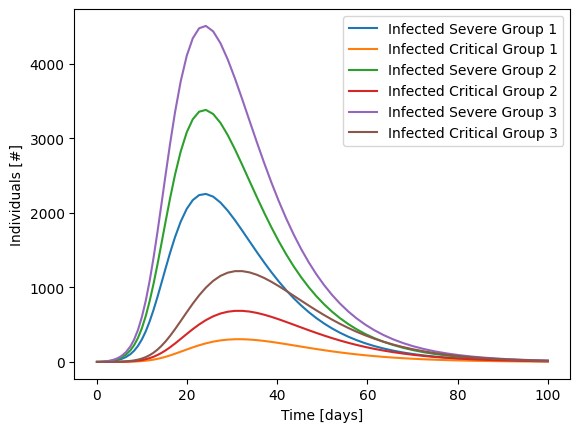

In [94]:
# Get number of time points
num_time_points = result.get_num_time_points()

# Convert time series to array
result_array = result.as_ndarray()

# Plot the number of infected with symptoms over time
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
time = result_array[0, :]
ax.plot(time, result_array[1 + int(osecir.InfectionState.InfectedSevere), :], label='Infected Severe Group 1')
ax.plot(time, result_array[1 + int(osecir.InfectionState.InfectedCritical), :], label='Infected Critical Group 1')
ax.plot(time, result_array[1 + (int(osecir.InfectionState.Dead) + 1) + int(osecir.InfectionState.InfectedSevere), :], label='Infected Severe Group 2')
ax.plot(time, result_array[1 + (int(osecir.InfectionState.Dead) + 1) + int(osecir.InfectionState.InfectedCritical), :], label='Infected Critical Group 2')
ax.plot(time, result_array[1 + 2 * (int(osecir.InfectionState.Dead) + 1) + int(osecir.InfectionState.InfectedSevere), :], label='Infected Severe Group 3')
ax.plot(time, result_array[1 + 2 * (int(osecir.InfectionState.Dead) + 1) + int(osecir.InfectionState.InfectedCritical), :], label='Infected Critical Group 3')
ax.set_xlabel('Time [days]')
ax.set_ylabel('Individuals [#]')
ax.legend()
plt.show()